In [3]:
pip install tensorflow==2.11.*

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [5]:
path = Path("UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [6]:
print(len(filenames))
print(filenames[:3])

23708
['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg']


In [7]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [8]:
image_path

['23_1_2_20170116172910708.jpg.chip.jpg',
 '28_0_1_20170113150719161.jpg.chip.jpg',
 '26_1_0_20170116234741431.jpg.chip.jpg',
 '37_0_3_20170119202516470.jpg.chip.jpg',
 '60_0_0_20170109013457906.jpg.chip.jpg',
 '2_0_2_20161219162359990.jpg.chip.jpg',
 '8_0_0_20170110222913531.jpg.chip.jpg',
 '34_1_4_20170113011428472.jpg.chip.jpg',
 '48_1_0_20170109220544479.jpg.chip.jpg',
 '54_0_0_20170113210319475.jpg.chip.jpg',
 '63_0_0_20170113210318902.jpg.chip.jpg',
 '35_1_1_20170113001239705.jpg.chip.jpg',
 '9_1_0_20170109202813775.jpg.chip.jpg',
 '29_1_1_20170116171830504.jpg.chip.jpg',
 '56_1_0_20170103180406295.jpg.chip.jpg',
 '35_0_3_20170119201257884.jpg.chip.jpg',
 '5_0_0_20170109193414770.jpg.chip.jpg',
 '1_0_2_20161219203256078.jpg.chip.jpg',
 '14_0_3_20170104225721488.jpg.chip.jpg',
 '27_0_0_20170113210319553.jpg.chip.jpg',
 '61_1_0_20170117192059259.jpg.chip.jpg',
 '27_0_0_20170117175751139.jpg.chip.jpg',
 '34_0_4_20170105161411273.jpg.chip.jpg',
 '35_0_0_20170117204518056.jpg.chip.jpg

In [9]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [10]:
df.head()

,image,age,gender
0,23_1_2_20170116172910708.jpg.chip.jpg,23,1
1,28_0_1_20170113150719161.jpg.chip.jpg,28,0
2,26_1_0_20170116234741431.jpg.chip.jpg,26,1
3,37_0_3_20170119202516470.jpg.chip.jpg,37,0
4,60_0_0_20170109013457906.jpg.chip.jpg,60,0


In [11]:
gender_dict = {0:"Male",1:"Female"}

In [12]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [13]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


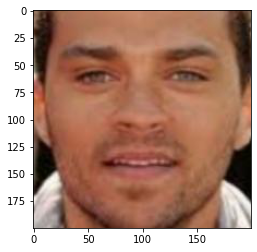

In [14]:
img = Image.open("UTKFace/"+df.image[1])
plt.imshow(img)

C:\Users\swara\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

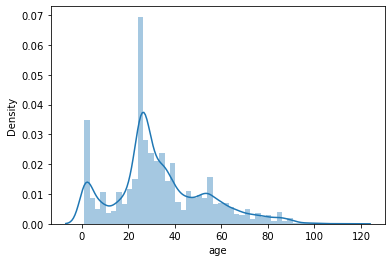

In [15]:
sns.distplot(df.age)

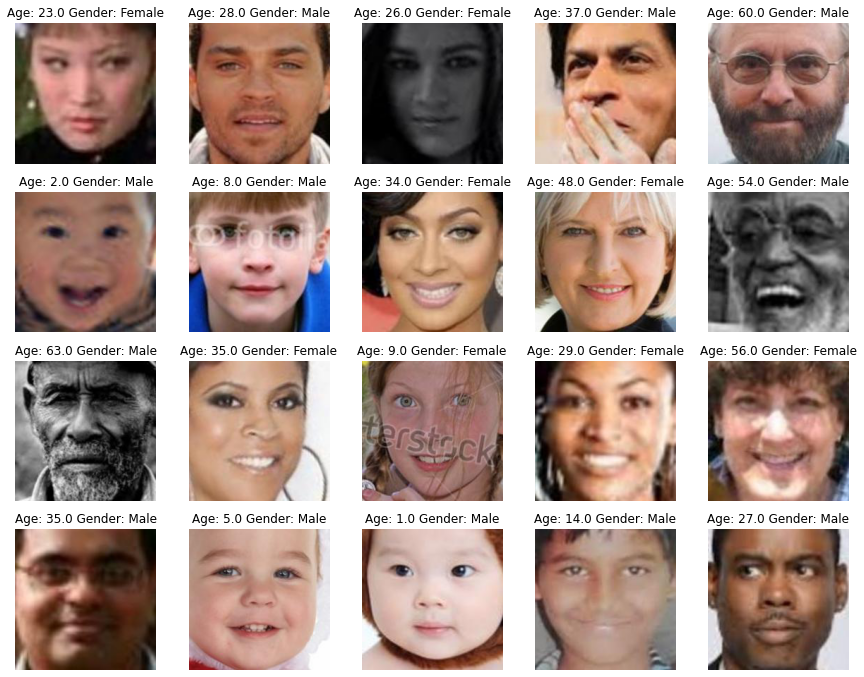

In [16]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [17]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [18]:
train.head()

,image,age,gender
18199,78_1_1_20170113011857601.jpg.chip.jpg,78.0,1
19557,24_0_2_20170103223924087.jpg.chip.jpg,24.0,0
20132,34_1_3_20170119152405425.jpg.chip.jpg,34.0,1
11849,46_0_3_20170119183135878.jpg.chip.jpg,46.0,0
2100,30_0_2_20170116174814595.jpg.chip.jpg,30.0,0


In [19]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

C:\Users\swara\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [20]:
x_train.shape

(3556, 128, 128, 1)

In [21]:
x_train = x_train/255

In [22]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [23]:
input_size = (128,128,1)

In [24]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [25]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [27]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
320/320 [==============================] - 125s 380ms/step - loss: 17.6598 - gender_output_loss: 0.6991 - age_output_loss: 16.9607 - gender_output_accuracy: 0.6347 - age_output_accuracy: 0.0491 - val_loss: 19.8735 - val_gender_output_loss: 0.6435 - val_age_output_loss: 19.2300 - val_gender_output_accuracy: 0.6320 - val_age_output_accuracy: 0.0534
Epoch 2/20
320/320 [==============================] - 121s 377ms/step - loss: 13.4172 - gender_output_loss: 0.5175 - age_output_loss: 12.8997 - gender_output_accuracy: 0.7409 - age_output_accuracy: 0.0441 - val_loss: 13.0630 - val_gender_output_loss: 0.4805 - val_age_output_loss: 12.5825 - val_gender_output_accuracy: 0.7669 - val_age_output_accuracy: 0.0393
Epoch 3/20
320/320 [==============================] - 121s 377ms/step - loss: 11.7938 - gender_output_loss: 0.4392 - age_output_loss: 11.3546 - gender_output_accuracy: 0.7937 - age_output_accuracy: 0.0284 - val_loss: 9.8659 - val_gender_output_loss: 0.3628 - val_age_output_loss: 

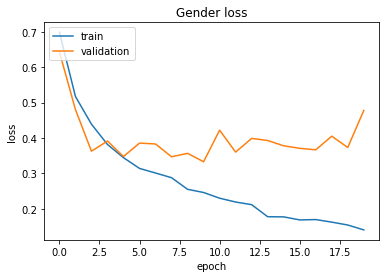

In [28]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

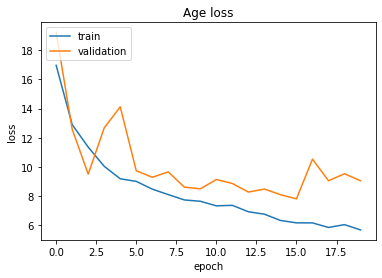

In [29]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Original: Gender =  Male  Age =  35.0
1/1 [==============================] - 0s 208ms/step
Prediction: Gender =  Male  Age =  50


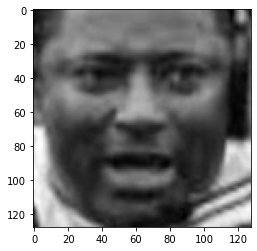

In [30]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Female  Age =  35.0
1/1 [==============================] - 0s 28ms/step
Prediction: Gender =  Female  Age =  47


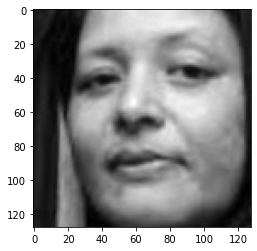

In [31]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Male  Age =  36.0
1/1 [==============================] - 0s 26ms/step
Prediction: Gender =  Male  Age =  41


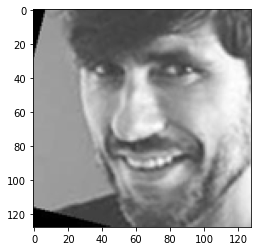

In [32]:
index=39
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Female  Age =  27.0
1/1 [==============================] - 0s 35ms/step
Prediction: Gender =  Female  Age =  36


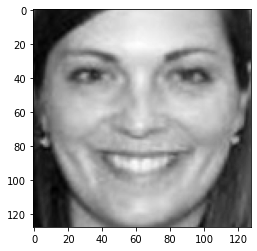

In [33]:
index=57
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Female  Age =  88.0
1/1 [==============================] - 0s 32ms/step
Prediction: Gender =  Female  Age =  88


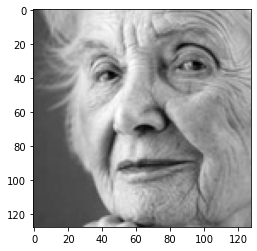

In [34]:
index=77
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')